In [3]:
%load_ext autoreload
%autoreload 2
#
import os
import random
from glob import glob
from pathlib import Path

import dask
import numpy as np
import torch
import xarray as xr
import zarr

# from dataclasses import dataclass
from dlboost.datasets.boilerplate import recon_one_scan

# from einops import rearrange
from lightning.pytorch import LightningDataModule
from matplotlib.pylab import f
from mrboost import computation as comp
from mrboost.reconstruction import BlackBone_LowResFrames

# from mrboost import io_utils as iou
from torch.utils.data import DataLoader

/bmrc-homes/nmrgrp/nmr201/micromamba/envs/python311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class BlackBone(LightningDataModule):
    def __init__(
        self,
        data_dir: os.PathLike = "/data/anlab/RawData_MR/",
        dat_file_path_list: list[str] = [],
        motion_curve_path_list: list[str] = [],
        cache_dir: os.PathLike = Path("/data-local/anlab/Chunxu/.cache"),
        rand_idx: list = [],
        n_splits: int = 6,
        fold_idx: int = 0,
        patch_size=(20, 320, 320),
        patch_sample_number=5,
        train_batch_size: int = 4,
        eval_batch_size: int = 1,
        num_workers: int = 0,
    ):
        super().__init__()
        self.patch_size = patch_size
        self.patch_sample_number = patch_sample_number

        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.val_batch_size = eval_batch_size
        self.data_dir = Path(data_dir)
        self.cache_dir = Path(cache_dir) / ".BlackBone"
        self.num_workers = num_workers
        # self.rand_idx = rand_idx
        # self.n_splits = n_splits
        # print(fold_idx)
        # self.fold_idx = fold_idx

        self.dat_file_path_list = dat_file_path_list
        self.motion_curve_path_list = motion_curve_path_list
        self.patient_ids = [
            (self.data_dir / p).parent.name for p in self.dat_file_path_list
        ]

        # print("rand_idx: ", rand_idx)
        # splits = np.array_split(rand_idx, n_splits)
        # print("splits: ", splits)
        # self.val_idx = splits.pop(fold_idx)
        # self.train_idx = np.concatenate(splits)
        # self.train_patient_ids = [self.patient_ids[i] for i in self.train_idx]
        self.train_patient_ids = self.patient_ids
        self.val_patient_ids = [self.patient_ids[i] for i in [0, 1]]
        # print("validation patient ids: ", [self.patient_ids[i] for i in self.val_idx])
        # print("training patient ids: ", [self.patient_ids[i] for i in self.train_idx])

    def prepare_data(self):
        # self.train_save_path = self.cache_dir / str(self.fold_idx) / "train"
        self.train_save_path = self.cache_dir / "train"
        train_integrate = False
        if os.path.exists(self.train_save_path):
            if len(glob(str(self.train_save_path / "*.zarr"))) == len(
                self.train_idx
            ) + len(self.val_idx):
                train_integrate = True
        if not train_integrate:
            print(self.train_save_path)
            self.generate_train_dataset(self.train_save_path)
        return
        # self.val_save_path = self.cache_dir / str(self.fold_idx) / "val"
        self.val_save_path = self.cache_dir / "val"
        val_integrate = False
        if os.path.exists(self.val_save_path):
            if len(glob(str(self.val_save_path / "*.zarr"))) == len(
                self.train_idx
            ) + len(self.val_idx):
                val_integrate = True
        if not val_integrate:
            self.generate_val_dataset(self.val_save_path)

    def generate_val_dataset(self, val_save_path):
        for p, patient_id in zip(self.dat_file_path_list, self.patient_ids):
            dat_file_to_recon = Path(self.data_dir) / p
            if os.path.exists(val_save_path / (patient_id + ".zarr")):
                continue
            raw_data = recon_one_scan(
                dat_file_to_recon, phase_num=5, time_per_contrast=10
            )
            if os.path.exists(val_save_path / (patient_id + ".zarr")):
                continue
            ds = xr.Dataset(
                data_vars=dict(
                    kspace_data=xr.Variable(
                        ["t", "ph", "ch", "z", "sp", "lens"],
                        raw_data["kspace_data_z"].numpy(),
                    ),
                    kspace_data_compensated=xr.Variable(
                        ["t", "ph", "ch", "z", "sp", "lens"],
                        raw_data["kspace_data_z_compensated"].numpy(),
                    ),
                    kspace_data_cse=xr.Variable(
                        ["t", "ph2", "ch", "z", "sp2", "lens2"],
                        raw_data["kspace_data_z"][..., 240:400].numpy(),
                    ),
                    kspace_traj=xr.Variable(
                        ["t", "ph", "complex", "sp", "lens"],
                        raw_data["kspace_traj"].numpy(),
                    ),
                    kspace_traj_cse=xr.Variable(
                        ["t", "ph2", "complex", "sp2", "lens2"],
                        raw_data["kspace_traj"][..., 240:400].numpy(),
                    ),
                    cse=xr.Variable(["ch", "z", "h", "w"], raw_data["cse"].numpy()),
                ),
                attrs={"id": patient_id},
            )
            ds = (
                ds.stack({"k": ["sp", "lens"]})
                .stack({"k2": ["ph2", "sp2", "lens2"]})
                .chunk(
                    {
                        "t": 1,
                        "ph": -1,
                        "ch": -1,
                        "z": 1,
                        "k": -1,
                        "k2": -1,
                        "complex": -1,
                        "h": -1,
                        "w": -1,
                    }
                )
            )
            ds = ds.reset_index(list(ds.indexes))
            ds.to_zarr(val_save_path / (patient_id + ".zarr"))

    def generate_train_dataset(self, train_save_path):
        # iou.check_mk_dirs(self.cache_dir / str(self.fold_idx))
        for p, m, patient_id in zip(
            self.dat_file_path_list, self.motion_curve_path_list, self.patient_ids
        ):
            print(p, m, patient_id)
            dat_file_location = Path(self.data_dir) / p
            motion_curve_location = Path(self.data_dir) / m
            if os.path.exists(train_save_path / (patient_id + ".zarr")):
                continue
            r = BlackBone_LowResFrames(
                dat_file_location, motion_curve_location, device=torch.device("cuda:1")
            )
            data_raw = r.get_raw_data(r.dat_file_location)
            r.args_init()
            data_dict = r.data_preprocess(data_raw)
            frame_num = len(data_dict["kspace_data_z"])
            print(frame_num, data_dict["kspace_data_z"][0].shape)
            dims = [["ch", "z", f"sp_{i}", "lens"] for i in range(frame_num)]
            dims.extend([["complex", f"sp_{i}", "lens"] for i in range(frame_num)])
            dims.extend([[f"sp_{i}", "lens"] for i in range(frame_num)])
            dims.extend([["ch", "z", "h", "w"]])
            keys = [f"kspace_data_z_{i}" for i in range(frame_num)]
            keys.extend([f"kspace_traj_{i}" for i in range(frame_num)])
            keys.extend([f"kspace_density_compensation_{i}" for i in range(frame_num)])
            keys.extend(["csm"])
            values = [data_dict["kspace_data_z"][i] for i in range(frame_num)]
            values.extend([data_dict["kspace_traj"][i] for i in range(frame_num)])
            values.extend(
                [data_dict["kspace_density_compensation"][i] for i in range(frame_num)]
            )
            values.extend([data_dict["cse"].coil_sens])

            variable_dict = dict()
            for d, k, v in zip(dims, keys, values):
                variable_dict[k] = xr.Variable(d, v.numpy())

            ds = xr.Dataset(
                data_vars=variable_dict,
                attrs={"id": patient_id},
            )

            chunk_dict = dict()
            print(dims)
            for d in dims:
                for dim in d:
                    if dim == "z":
                        chunk_dict[dim] = 1
                    else:
                        chunk_dict[dim] = -1

            ds = ds.chunk(chunk_dict)
            ds = ds.reset_index(list(ds.indexes))
            ds.to_zarr(train_save_path / (patient_id + ".zarr"))

    def setup(self, init=False, stage: str = "fit"):
        dask.config.set(scheduler="synchronous")
        train_ds_list = [
            str(self.cache_dir / "train" / f"{pid}.zarr")
            for pid in self.train_patient_ids
        ]
        if stage == "fit":
            # str(self.cache_dir / str(self.fold_idx) / "train" / "*.zarr")
            sample = xr.open_zarr(train_ds_list[0])
            t = sample.sizes["t"]
            z = sample.sizes["z"]
            t_indices = [i for i in range(t)]
            # z axis have z slices, we want to randomly sample n patches from these slices, each patch have p slices.
            z_indices = [
                slice(start_idx, self.patch_size[0] + start_idx)
                for start_idx in random.sample(
                    range(z - self.patch_size[0]), self.patch_sample_number
                )
            ]
            self.train_dp = [
                xr.open_zarr(train_ds).isel(t=t_idx, z=z_idx)
                # xr.open_zarr(train_ds).isel(t=t_idx)
                for train_ds in train_ds_list
                for t_idx in t_indices
                for z_idx in z_indices
            ]
        else:
            self.train_dp = [xr.open_zarr(ds) for ds in train_ds_list]

        val_ds_list = [
            (
                str(self.cache_dir / "val" / f"{pid}.zarr"),
                str((self.cache_dir / "val" / f"{pid}_P2PCSE.zarr")),
            )
            for pid in self.patient_ids[2:3]
        ]
        self.val_dp = [
            (
                xr.open_zarr(ds).isel(t=slice(0, 1), z=slice(36, 44)),
                xr.open_zarr(init).isel(t=slice(0, 1), z=slice(36, 44)),
            )
            for ds, init in val_ds_list
        ]
        # self.pred_dp = [xr.open_zarr(ds) for ds in val_ds_list]

    def train_dataloader(self):
        train_keys = [
            "kspace_data_odd",
            "kspace_data_even",
            "kspace_data_cse_odd",
            "kspace_data_cse_even",
            "kspace_traj_odd",
            "kspace_traj_even",
            "kspace_traj_cse_odd",
            "kspace_traj_cse_even",
            "P2PCSE_odd",
            "P2PCSE_even",
        ]

        def collate_fn(batch_list):
            batch = {k: [] for k in train_keys}
            for x in batch_list:
                for k in train_keys:
                    batch[k].append(torch.from_numpy(x[k].to_numpy()))
            return {k: torch.stack(v) for k, v in batch.items()}

        return DataLoader(
            self.train_dp,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
            collate_fn=collate_fn,
        )

    def val_dataloader(self):
        val_keys = [
            "kspace_data",
            "kspace_data_cse",
            "kspace_traj",
            "kspace_traj_cse",
            "P2PCSE",
        ]

        def collate_fn(batch_list):
            return_list = []
            for kd, init in batch_list:
                batch = {k: None for k in val_keys}
                for k in val_keys:
                    if k == "P2PCSE":
                        batch[k] = torch.from_numpy(init[k].to_numpy())
                    else:
                        batch[k] = torch.from_numpy(kd[k].to_numpy())
                return_list.append(batch)
            return return_list

        return DataLoader(
            self.val_dp,
            batch_size=self.val_batch_size,
            num_workers=0,
            pin_memory=False,
            collate_fn=collate_fn,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.val_dp,
            batch_size=self.val_batch_size,
            num_workers=0,
            pin_memory=False,
            collate_fn=lambda batch_list: [
                (x, {k: torch.from_numpy(v.to_numpy()) for k, v in x.data_vars.items()})
                for x in batch_list
            ],
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dp,
            batch_size=self.val_batch_size,
            num_workers=1,
            pin_memory=False,
            collate_fn=lambda batch_list: [
                (x, {k: torch.from_numpy(v.to_numpy()) for k, v in x.data_vars.items()})
                for x in batch_list
            ],
        )

    def transfer_batch_to_device(
        self, batch, device: torch.device, dataloader_idx: int
    ):
        if self.trainer.training:
            return super().transfer_batch_to_device(batch, device, dataloader_idx)
        else:
            return batch

In [8]:
from omegaconf import OmegaConf as O

kwargs = O.load("/bmrc-an-data/Chunxu/blackbone/configs/N2N.yaml")["data"]["init_args"]
data = BlackBone(**kwargs)
data.prepare_data()
# data.setup()

/bmrc-an-data/Chunxu/.cache/.BlackBone/train
ACR_Phantom_Feb2022/M/Feb2022_(Actual)_Results/meas_MID00373_FID49006_fl3d_vibe_GA_Blackbone_20181203_M.dat ACR_Phantom_Feb2022/M/Feb2022_(Actual)_Results/MotionParameters_Jul_MID00373_FID49006_f0181203_M.mat Feb2022_(Actual)_Results
pymapVBVD version 0+untagged.22.gac0eb13.dirty
Software version: VD


read data:  14%|█▎        | 8568/62800 [00:05<00:27, 1975.13it/s]/bmrc-an-data/Chunxu/mrboost/src/mrboost/mapvbvd/twix_map_obj.py:870: RuntimeWarning: invalid value encountered in add
  raw = (raw[:, 0] + 1j * raw[:, 1]).reshape(readShape, order="F")
100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


7 torch.Size([30, 225, 84, 640])
[['ch', 'z', 'sp_0', 'lens'], ['ch', 'z', 'sp_1', 'lens'], ['ch', 'z', 'sp_2', 'lens'], ['ch', 'z', 'sp_3', 'lens'], ['ch', 'z', 'sp_4', 'lens'], ['ch', 'z', 'sp_5', 'lens'], ['ch', 'z', 'sp_6', 'lens'], ['complex', 'sp_0', 'lens'], ['complex', 'sp_1', 'lens'], ['complex', 'sp_2', 'lens'], ['complex', 'sp_3', 'lens'], ['complex', 'sp_4', 'lens'], ['complex', 'sp_5', 'lens'], ['complex', 'sp_6', 'lens'], ['sp_0', 'lens'], ['sp_1', 'lens'], ['sp_2', 'lens'], ['sp_3', 'lens'], ['sp_4', 'lens'], ['sp_5', 'lens'], ['sp_6', 'lens'], ['ch', 'z', 'h', 'w']]
BlackBoneReprocess_Apr2021/MUFFIN_HealthyVolunteers/VOLUNTEER1_AUG21_VOLUNTEER1_AUG21/meas_MID00490_FID54382_fl3d_vibe_GA_LargeMotion.dat BlackBoneReprocess_Apr2021/MUFFIN_HealthyVolunteers/VOLUNTEER1_AUG21_VOLUNTEER1_AUG21/MotionParameters_Jul_MID00490_FID54382_frgeMotion.mat VOLUNTEER1_AUG21_VOLUNTEER1_AUG21
pymapVBVD version 0+untagged.22.gac0eb13.dirty
Software version: VD


read data:  14%|█▍        | 8811/62800 [00:09<00:48, 1123.60it/s]/bmrc-an-data/Chunxu/mrboost/src/mrboost/mapvbvd/twix_map_obj.py:870: RuntimeWarning: invalid value encountered in add
  raw = (raw[:, 0] + 1j * raw[:, 1]).reshape(readShape, order="F")
100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


IndexError: index 400 is out of bounds for dimension 0 with size 400

In [15]:
import nibabel as nib

hdr_file_path = "/bmrc-an-data/Cihat/ACR_Phantom_Feb2022/M/Feb2022_(Actual)_Results/LowResFrames_Jul_MID00373_FID49006_f0181203_M.hdr"
image = nib.load(hdr_file_path)
image_data = image.get_fdata()

In [16]:
image_data.shape

(320, 320, 1176, 1)

In [46]:
from einops import rearrange

image = rearrange(image_data, "h w (z f) ()-> h w z f", f=7)

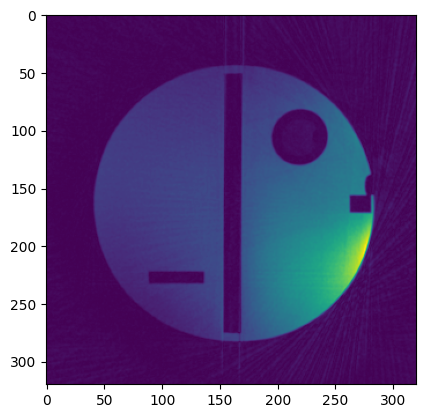

In [71]:
from matplotlib import pyplot as plt

plt.imshow(image[:, :, 65, 0])

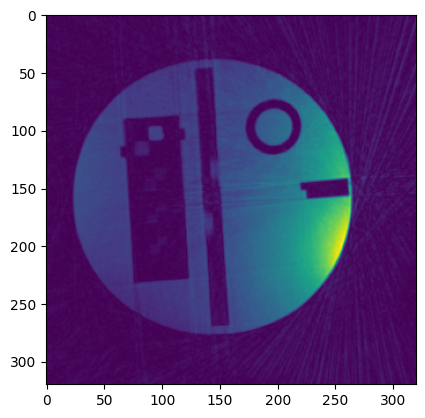

In [94]:
plt.imshow(image[:, :, 45, 6])

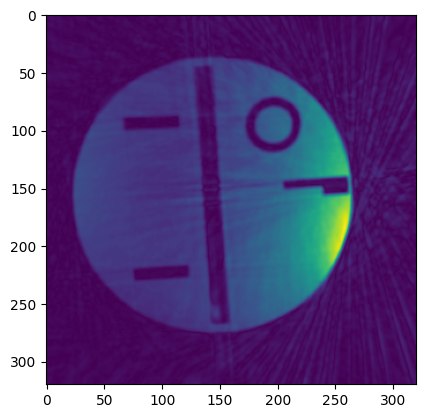

In [95]:
plt.imshow(image[:, :, 45, 5])

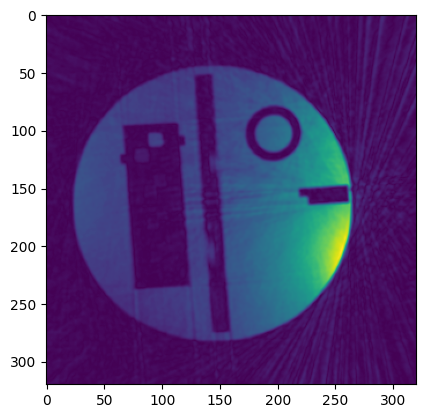

In [96]:
plt.imshow(image[:, :, 45, 4])

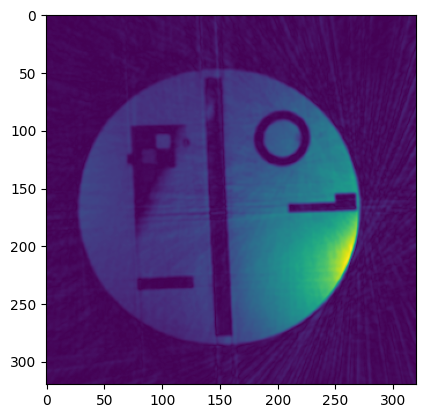

In [100]:
plt.imshow(image[:, :, 45, 3])

In [ ]:
plt.imshow(image[:, :, 45, 2])